In [1]:
# Imports

import numpy as np
import numpy.linalg as la
import scipy.linalg.interpolative as sli
import matplotlib as mp
import matplotlib.cm as cm
import scipy

from scipy.misc import imresize
from scipy.fftpack import dct
from scipy.ndimage import interpolation

# if available import pylab (from matlibplot)
try:
    import matplotlib.pylab as plt
except ImportError:
    pass

In [2]:
import scipy.io.wavfile as wavfile
from IPython.display import Audio

In [3]:
first_half = lambda l: l[1:(1+len(l)/2)]
power = lambda z: np.absolute(z)

def frequencies(f, Fs):
    x = np.linspace(0, Fs, len(f), endpoint=False)
    x[len(f)/2:] -= Fs # second half starts at lowest negative frequency
    return x

def freqcompare(y, Fs):
    powerfft = power(np.fft.fft(y))
    x = frequencies(y, Fs)
    plt.subplot(1,2,1)
    plt.plot(np.arange(len(y))*1./Fs, y)
    plt.xlim(0,len(y)*1./Fs)
    plt.ylim(min(y)-1,max(y)+1)
    plt.subplot(1,2,2)
    plt.plot(x, powerfft)
    plt.xlim(min(x)-1,max(x)+1)
    plt.ylim(0,max(powerfft)+1)
    plt.show()

nearest_2power = lambda x: int(np.log2(x))

In [4]:
semitone = 2.**(1./12.)

def genNotes(octaves):
    # instead of multiplying by 2^(1/12) over and over, we reduce drift/error
    # by creating all the C tones, which are multiples of 2 away from each other
    c_freqs = np.array([130.81*(2**i) for i in range(octaves)])
    ratios = np.array([semitone**i for i in range(12)]) 
    return np.dot(c_freqs[:, None], ratios[None, :]).flatten() # indexing with "None" adds an empty dimension

notes = genNotes(octaves=5)

# add an extra note below and above, so the dividing lines for the first and last C get computed properly
notes_expanded = np.concatenate(([notes[0]/semitone], notes, [notes[-1]*semitone]))
dividers = (notes_expanded[:-1]+notes_expanded[1:])/2. # calc dividing lines using average
dividers = np.array([dividers[:-1],dividers[1:]]).T # make each element a pair of dividing lines

def note_power(power, Fs):
    x = frequencies(power, Fs)
    return np.array([max(power[(x >= left) & (x < right)]) for left,right in dividers])


In [5]:
# some tests to make sure my key is correct

tone = lambda freq, t=8., Fs=44100., angle=0.: np.cos(freq*2*np.pi*np.linspace(0, t, Fs*t, endpoint=False)+angle)

def playFreq(freq):
    t = 8. # 8 seconds
    Fs = 44100.
    return Audio(tone(freq,t,Fs), rate=Fs)


## Multiple Instruments

In [6]:
Fs, rawsakae = wavfile.read('sakaeinaction.wav')

print Fs # make sure Fs matches all previous Fs
print rawsakae.shape

44100
(8353916L, 2L)


In [7]:
# reformat the data to match output of octave's wavread (divide by INT_MAX to normalize amplitude to [-1,1])
rawsakae1 = (rawsakae*1.)/np.iinfo(rawsakae[0][0]).max
rawsakae1 = rawsakae1[:,0] # only keep the first track

sakae = rawsakae1[:2**nearest_2power(rawsakae1.shape[0])] # clip end to make data length a power of 2

In [8]:
sakae_beginning = sakae[:2**18]

In [9]:
sakae_offset = sakae[44100:]

In [10]:
class Sampler:
    def __init__(self, song, N, offset=0, Fs=44100.):
        self.song = song
        self.N = N # sample size
        self.Fs = Fs
        self.w1_vec = np.fft.fft(np.arange(N) == 1) # extract the [1 w w^2 w^3...] vector using an fft of [0 1 0 0 0 ...]
        self.wN_vec = np.fft.fft(np.arange(N) == N-1) # extract the [1 w^(N-1) w^2(N-1) ...] using an fft of [0 0 0 ... 0 1]
        self.frequencies = frequencies(np.arange(self.N), self.Fs)
        self.reset(offset)
    
    def next(self):
        if (len(self.song) <= self.offset+self.N):
            return np.zeros(self.N) # song finished, just return zeros
        
        old_datum = self.song[self.offset]
        new_datum = self.song[self.offset+self.N]
        self.offset += 1
        self.dft = (self.dft-old_datum)/self.w1_vec + new_datum*self.wN_vec
        return self.dft
        
    def reset(self, offset=0):
        self.offset = offset
        self.dft = np.fft.fft(self.song[self.offset:self.offset+self.N])
        return self.dft
    
    def current_sample(self):
        return self.song[self.offset:self.offset+self.N]

In [11]:
sakaeSampler = Sampler(sakae_offset, 1024)

In [12]:
class DominantFrequencySampler(Sampler):
    def getDominantFrequencies(self, n=5):
        power_half = power(first_half(self.dft)[:-1]) # exclude the last frequency, because it *could* be the lowest negative freq
        top_powers = np.argpartition(power_half, -n)[-n:] # use argpartition to get indices of top n frequencies
        top_powers = top_powers[np.argsort(power_half[top_powers])][::-1] # sort the top frequency indices in descending order
        self.top_freqs = self.frequencies[top_powers+1] # add 1 because power_half starts at index 1 (not 0)
        self.top_magnitudes = power_half[top_powers]
        self.top_phases = np.angle(self.dft[top_powers+1])
        return (self.top_freqs, self.top_magnitudes, self.top_phases)

In [13]:
lowSampler = DominantFrequencySampler(sakae_offset, Fs/20)

In [14]:
sakae5Secs = sakae[:44100*5]

lowSampler2 = DominantFrequencySampler(sakae5Secs, Fs/20) # only look at first 5 seconds

In [15]:
oneSec = Fs # number of frames for 1 second

In [16]:
indx1760 = np.nonzero((lowSampler2.frequencies > 1755) & (lowSampler2.frequencies < 1765))[0][0] # index of freq ~880

A6PowerOverTime = power([lowSampler2.next()[indx1760] for i in range(oneSec*2)])

In [18]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n-1:] / n


In [20]:
len(test.song)

4194304

In [156]:
humanHearing = np.nonzero((testjump.frequencies > 20) & (testjump.frequencies < 20000))[0]

## Overview

In [22]:
import timeit

In [25]:
test = Sampler(sakae, Fs/20)

start_time = timeit.default_timer()

testresult = [test.next() for i in range(50000)]

print "elapsed: " + str(timeit.default_timer() - start_time)

elapsed: 13.5991764045


In [26]:
test2 = DominantFrequencySampler(sakae, Fs/20)

start_time = timeit.default_timer()

test2result = [test2.next() for i in range(50000)]

print "elapsed: " + str(timeit.default_timer() - start_time)

elapsed: 13.5780246918


In [59]:
class JumpSampler(DominantFrequencySampler):
    def __init__(self, song, N, interval=4410, offset=0, Fs=44100.):
        DominantFrequencySampler.__init__(self, song, N, offset, Fs)
        self.interval = interval
        
    def jump(self):
        return self.reset(self.offset+self.interval)

In [176]:
freqCrop = np.nonzero((testjump.frequencies > 20) & (testjump.frequencies < 5000))[0]

In [188]:
testjump = JumpSampler(sakae, Fs/20, 441)

print testjump.reset().shape
testjumpresults = []
while testjump.offset < len(testjump.song) - testjump.N - testjump.interval:
    testjumpresults.append(power(testjump.jump()[freqCrop]))

testjumpresults = np.array(testjumpresults)
print np.array(testjumpresults).shape

(2205L,)
(9505L, 248L)


In [189]:
#testjumpresults = np.array(testjumpresults[:-(len(testjumpresults)%10)])
print testjumpresults.shape

(9505L, 248L)


(1901L, 5L, 248L)


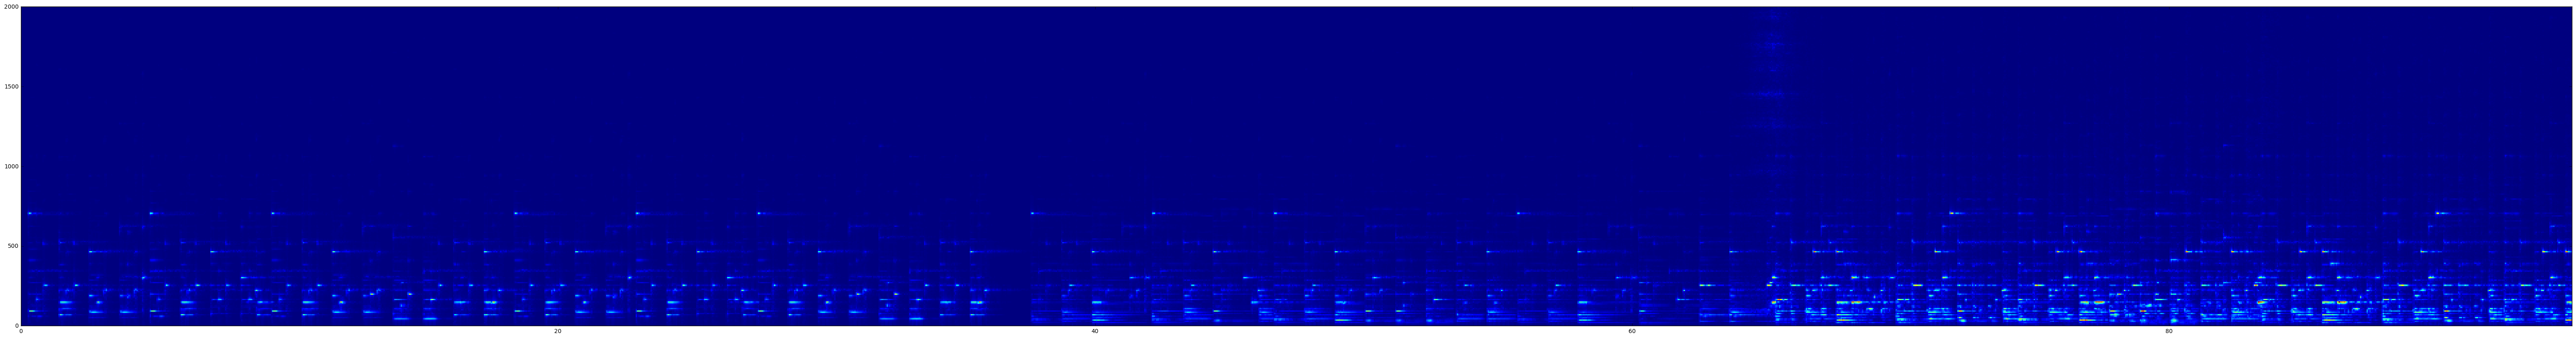

In [195]:
spectrum = testjumpresults.reshape((testjumpresults.shape[0]/5,5,testjumpresults.shape[1]))

print spectrum.shape

spectrum = np.mean(spectrum, axis=1)

plt.figure(figsize=(80,10))
#spectrum = interpolation.zoom(spectrum, [1,20])
plt.imshow(spectrum.T, aspect='auto', interpolation='none', extent=[0,95,2000,0])
plt.gca().invert_yaxis()
plt.show()

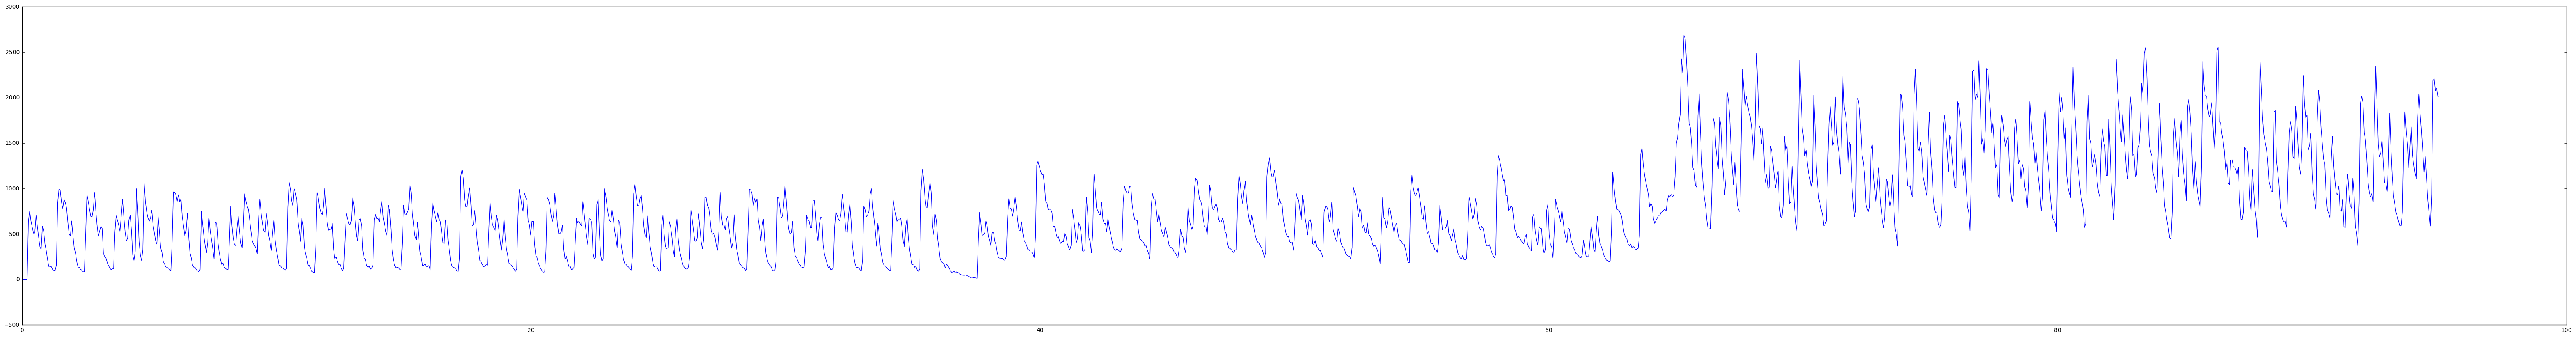

In [199]:
plt.figure(figsize=(80,10))
plt.plot(np.linspace(0,95,len(spectrum),endpoint=False), np.sum(spectrum, axis=1))
plt.show()